## Image Captioning

- Input: image.
- Output: A sequence of words in a natural language, which hopefully describes the contents of the input Image.

## Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence

import torchvision.transforms as transforms
import torchvision.models as models

#from utils import *
from build_vocab import build_vocab
from data_loader import get_loader

# setup
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


### Helper functions

In [2]:
def load_cnn_model(model_name, pretrained=True):
    "Load and return a convolutional neural network."
    assert model_name in ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']
    return models.__dict__[model_name](pretrained)


def load_image(image_path, transform=None):
    "Load an image and perform given transformations."
    image = Image.open(image_path)    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

## Data

- [Microsoft COCO Dataset](http://cocodataset.org/#captions-2015)
- More than 80k training images and 40k validation images.
- At leat 5 captions for every image.

### Load Images and Captions Data

In [3]:
def load_json(filename='data/fa_images_captions_train.json'):
    with open(filename, 'r') as f:
        annotations = json.load(f)
    return annotations

dataset = load_json('/mnt/home/mnikzad/ML_Practice/Image_Captioning/cocoapi/annotations/captions_val2014.json')

In [4]:
print(dataset.keys())

dict_keys(['info', 'images', 'licenses', 'annotations'])


In [5]:
print(dataset['images'][0])

{'license': 3, 'file_name': 'COCO_val2014_000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}


In [6]:
print(dataset['annotations'][0])

{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}


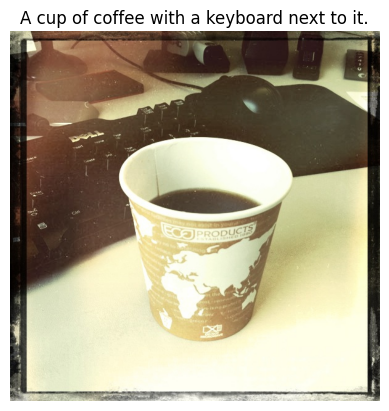

In [4]:

#show_random_image_with_caption(dataset)
def show_image(image_file, caption):
    img = plt.imread(image_file)
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, size='large')

# pick a random image and obtain the corresponding caption and filename
N = len(dataset['annotations'])
idx = np.random.choice(range(N))

item = dataset['annotations'][idx]
caption = item['caption']

img_id = item['image_id']

# Find the image file name corresponding to the img_id
filename = None
for image in dataset['images']:
    if image['id'] == img_id:
        filename = image['file_name']
        break

if filename is None:
    print(f"Image with id {img_id} not found.")
else:
    image_file = os.path.join('/mnt/home/mnikzad/ML_Practice/Image_Captioning/cocoapi/val2014/', filename)
    show_image(image_file, caption)

### Building vocabulary

In [71]:
DATA_DIR = 'data'
captions_filename = f'{DATA_DIR}/captions.txt'

N = len(dataset['annotations'])
for id in range(N):
    item = dataset['annotations'][id]
    caption = item['caption']
    with open(captions_filename, 'a') as file:
    # Append content to the file
        file.write(caption.lower() + '\n')

In [5]:
DATA_DIR = 'data'
#captions_filename = f'{DATA_DIR}/fa_captions.txt'
vocab_filename = f'{DATA_DIR}/vocab.pkl'

if os.path.exists(vocab_filename):
    vocab = pickle.load(open(vocab_filename, 'rb'))
else:
    vocab = build_vocab(captions_filename, min_count=0)
    pickle.dump(vocab, open(vocab_filename, 'wb'))

In [6]:
print(len(vocab))

17496


In [10]:
for i in range(100):
    print("%s --> %d" %(vocab.idx2word[i], i))

<PAD> --> 0
<BOS> --> 1
<EOS> --> 2
<UNK> --> 3
a --> 4
. --> 5
on --> 6
of --> 7
the --> 8
in --> 9
with --> 10
and --> 11
is --> 12
man --> 13
to --> 14
sitting --> 15
an --> 16
two --> 17
, --> 18
at --> 19
standing --> 20
people --> 21
are --> 22
next --> 23
white --> 24
woman --> 25
street --> 26
table --> 27
that --> 28
holding --> 29
it --> 30
large --> 31
person --> 32
some --> 33
top --> 34
down --> 35
up --> 36
group --> 37
field --> 38
tennis --> 39
front --> 40
black --> 41
small --> 42
train --> 43
near --> 44
his --> 45
dog --> 46
cat --> 47
plate --> 48
riding --> 49
room --> 50
red --> 51
young --> 52
by --> 53
water --> 54
has --> 55
playing --> 56
sign --> 57
bathroom --> 58
baseball --> 59
walking --> 60
while --> 61
blue --> 62
building --> 63
kitchen --> 64
side --> 65
there --> 66
food --> 67
green --> 68
bus --> 69
pizza --> 70
grass --> 71
parked --> 72
bed --> 73
other --> 74
clock --> 75
looking --> 76
beach --> 77
snow --> 78
toilet --> 79
for --> 80
ball -->

### Data loader

In [7]:
DATASET_DIR = '/mnt/home/mnikzad/ML_Practice/Image_Captioning/cocoapi/'
images_dir = f'{DATASET_DIR}/val2014'
captions_json = f'{DATASET_DIR}/annotations/captions_val2014.json'
image_size = 256
crop_size  = 224
batch_size = 16


transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

In [8]:
data_loader = get_loader(images_dir, captions_json, vocab, 
                         transform, batch_size, 
                         shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Word IDs: 3 16181 3 1507 4 1561 29 4 2316 2987 59 192 9 4 403 5821 16183 5
Words: <UNK> sinister <UNK> smoking a cigarette holding a blood soaked baseball bat in a dark demonic oom .


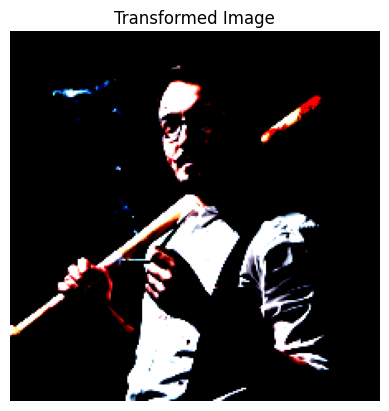

In [9]:
# Assuming data_loader is your PyTorch DataLoader
imgs, caps, lengths = next(iter(data_loader))

# Extracting the first caption and removing special tokens
first_caption_ids = caps[0][1:-1]
first_img = imgs[0]
related_caption = " ".join([vocab.idx2word.get(id.item(), '<unk>') for id in first_caption_ids])
# Print word IDs
print("Word IDs:", " ".join([str(id.item()) for id in first_caption_ids]))

# Print corresponding words, handling missing indices
print("Words:", " ".join([vocab.idx2word.get(id.item(), '<unk>') for id in first_caption_ids]))

plt.imshow(first_img.permute(1, 2, 0))  # Convert CHW to HWC format for imshow
plt.axis('off')  # Hide axis for better visualization
plt.title("Transformed Image")
plt.show()

In [10]:
imgs.size()

torch.Size([16, 3, 224, 224])

In [11]:
print(caps.size())

torch.Size([16, 20])


## Model

<img src="imgs/enc-dec-arch.png" width="90%"/>

In [12]:
def to_var(x, requires_grad=False):
    if torch.cuda.is_available():
        #print(torch.cuda.is_available())
        x = x.cuda()
    return x.clone().detach().requires_grad_(requires_grad)

### Encoder (CNN)

In [82]:
class EncoderCNN(nn.Module):
    def __init__(self, model_name, embed_size):
        super(EncoderCNN, self).__init__()
        
        # Load pretrained CNN and remove the last fully connected layer
        cnn = self.load_cnn_model(model_name)
        modules = list(cnn.children())[:-1]  # remove the last layer
        
        self.cnn = nn.Sequential(*modules)
        self.linear = nn.Linear(cnn.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.init_weights()
                
    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.02)
        self.linear.bias.data.fill_(0)
        
    def forward(self, x):
        x = self.cnn(x)  # extract features from input image
        x = x.view(x.size(0), -1)  # flatten the output
        x = self.linear(x)
        x = self.bn(x)
        return x
    
    def fine_tune(self, requires_grad=True):
        for param in self.cnn.parameters():
            param.requires_grad = requires_grad

    def load_cnn_model(self, model_name):
        # Example function to load a CNN model from torchvision
        if model_name == 'resnet50':
            model = models.resnet50(pretrained=True)
        elif model_name == 'resnet101':
            model = models.resnet101(pretrained=True)
        else:
            raise ValueError(f"Model {model_name} is not supported.")
        
        return model

### Decoder (LSTM)

In [94]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, tie_weights=False, pretrained_embeddings=None, freeze_embeddings=False):
        """
        Initializes the DecoderLSTM class.

        Args:
            vocab_size (int): Size of the vocabulary.
            embed_size (int): Dimension of the word embeddings.
            hidden_size (int): Number of features in the hidden state of the LSTM.
            num_layers (int): Number of recurrent layers in the LSTM.
            dropout (float): Dropout probability for regularization.
            tie_weights (bool): Whether to tie the weights of the embedding and the final linear layer.
            pretrained_embeddings (Tensor, optional): Pre-trained embedding weights. Defaults to None.
            freeze_embeddings (bool, optional): Whether to freeze the embedding weights. Defaults to False.
        """
        super(DecoderLSTM, self).__init__()

        if tie_weights:
            assert embed_size == hidden_size, "Embedding size must match hidden size when tying weights"

        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)

        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(p=dropout)

        if tie_weights:
            # Share weights between embedding and classification layer
            self.fc.weight = self.embedding.weight

        self.init_weights(pretrained_embeddings)

    def init_weights(self, pretrained_embeddings):
        """Initializes the weights of the model."""
        if pretrained_embeddings is None:
            self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)

    def forward(self, features, captions, lengths):
        """
        Forward pass for the decoder.

        Args:
            features (Tensor): Image features from the encoder.
            captions (Tensor): Ground truth captions for training.
            lengths (list of int): Lengths of the captions.

        Returns:
            Tensor: The output of the decoder.
        """
        embeddings = self.embedding(captions)
        embeddings = torch.cat([features.unsqueeze(1), embeddings], dim=1)
        embeddings = self.dropout(embeddings)

        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed)
        lstm_output, _ = pad_packed_sequence(packed_output, batch_first=True)
        lstm_output = self.dropout(lstm_output)

        outputs = self.fc(lstm_output)
        return outputs

    def beam_search(self, features, states=None, max_length=25, beam_width=3):
        sequences = [[list(), 0.0]]
        inputs = features.unsqueeze(1)
        new_inputs = inputs.expand(-1, beam_width, -1)

        for _ in range(max_length):
            all_candidates = list()
            for seq, score in sequences:
                hiddens, states = self.lstm(new_inputs, states)  # (batch_size, 1, hidden_size)
                outputs = self.fc(hiddens.squeeze(1))        # (batch_size, vocab_size)
                log_probs, indices = torch.topk(outputs, beam_width)  # top-k scores

                for log_prob, idx in zip(log_probs[0], indices[0]):
                    candidate = [seq + [idx.item()], score - log_prob.item()]
                    all_candidates.append(candidate)

            ordered = sorted(all_candidates, key=lambda tup: tup[1])
            sequences = ordered[:beam_width]

            # Prepare the next inputs
            inputs = self.embedding(torch.tensor([seq[-1] for seq, _ in sequences], device=features.device)).unsqueeze(1)

        best_sequence = sequences[0][0]
        return best_sequence


In [84]:

def load_glove_embeddings(glove_file, vocab):
    """
    Load GloVe embeddings from a file and create an embedding matrix for a given vocabulary.

    Args:
        glove_file (str): Path to the GloVe file.
        vocab (dict): Vocabulary dictionary with word to index mappings.

    Returns:
        torch.Tensor: Embedding matrix with GloVe embeddings.
    """
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    embedding_dim = len(next(iter(embeddings_index.values())))
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    
    for word, i in vocab.word2idx.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return torch.tensor(embedding_matrix, dtype=torch.float32)

# Path to your GloVe file
glove_file = 'glove.6B.300d.txt'
vocab_filename = 'data/vocab.pkl'

if os.path.exists(vocab_filename):
    with open(vocab_filename, 'rb') as f:
        vocab = pickle.load(f)
else:
    raise FileNotFoundError("Vocabulary file not found.")

pretrained_embeddings = load_glove_embeddings(glove_file, vocab)

### Encoder-Decoder

In [95]:
class EncoderDecoder(nn.Module):
    
    def __init__(self, cnn_name, vocab_size, embed_size, hidden_size, num_layers, dropout, tie_weights, pretrained_embeddings=None):
        super(EncoderDecoder, self).__init__()
        
        if tie_weights:
            embed_size = hidden_size
            
        self.encoder = EncoderCNN(cnn_name, embed_size)
        self.decoder = DecoderLSTM(vocab_size, embed_size, hidden_size, num_layers, dropout, tie_weights, pretrained_embeddings)
        
        self.save_path = f'{cnn_name}-{embed_size}-{hidden_size}-{num_layers}'
        os.makedirs(self.save_path, exist_ok=True)
    
    def forward(self, images, captions, lengths):
        features = self.encoder(images)
        outputs = self.decoder(features, captions, lengths)
        return outputs
    
    def save(self, epoch, loss):
        save_filename = f'{self.save_path}/{epoch}-{loss:.2f}.pth'
        torch.save({
            'encoder': self.encoder.state_dict(),
            'decoder': self.decoder.state_dict()
        }, save_filename)
        print(f'Model saved to {save_filename}')
    
    def load(self, epoch):
        try:
            model_path = glob(f'{self.save_path}/{epoch}-*.pth')[-1]
            state_dict = torch.load(model_path)
            self.encoder.load_state_dict(state_dict['encoder'])
            self.decoder.load_state_dict(state_dict['decoder'])
            print(f'Model loaded from {model_path}')
        except IndexError:
            print(f'Error: Model for epoch {epoch} not found!')
        except Exception as e:
            print(f'Error loading model: {e}')

## Training

In [86]:
def train_epoch(model, train_dl, criterion, optimizer, scheduler, epoch, last_epoch):
    model.train()
    scheduler.step()
    
    total_steps = len(train_dl)
    epoch_loss = 0.0
    
    for i, (images, captions, lengths) in enumerate(train_dl):
        images, captions = to_var(images), to_var(captions)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
       # print("target_shape= ",targets.shape)
        # Forward pass
        outputs = model(images, captions, lengths)
        #print("output_from_Model_shape= ", outputs.shape)
        outputs = pack_padded_sequence(outputs, lengths, batch_first=True)[0]
        # Pack the outputs into a PackedSequence
       # packed_outputs = pack_padded_sequence(outputs, lengths, batch_first=True)
        #print("output_packed_Model_shape= ", packed_outputs.shape)
        # Unpack the outputs and targets
       # outputs_unpacked, _ = pad_packed_sequence(packed_outputs, batch_first=True)
       # print("output_unpacked_Model_shape= ", outputs_unpacked.shape)
       # print("output_unpacked_Model_re_shape= ", (outputs_unpacked.reshape(-1, outputs_unpacked.size(2))).shape)
        # Calculate the loss
        loss = criterion(outputs, targets)
        epoch_loss = (epoch_loss * i + loss.item()) / (i + 1)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        
        # Log training info
        sys.stdout.flush()
        sys.stdout.write('\rEpoch [%2d/%2d], Step [%3d/%3d], Loss = %.4f, Perplexity = %.4f    '
                         % (epoch+1, last_epoch, i+1, total_steps, epoch_loss, np.exp(epoch_loss)))
    print()

    return epoch_loss



def train(model, train_dl, criterion, optimizer, scheduler, start_epoch=0, num_epochs=10):
    last_epoch = start_epoch + num_epochs
    
    for epoch in range(start_epoch, last_epoch):                
        # Train for one epoch
        trn_loss = train_epoch(model, train_dl, criterion, optimizer, scheduler, epoch, last_epoch)
        
        # Save model
        # model.save(epoch, trn_loss)  # You can add saving functionality here if needed

### Encoder-Decoder

In [96]:
model = EncoderDecoder(
    cnn_name='resnet101',
    vocab_size=len(vocab),
    embed_size=300,  # Assuming 300-dimensional GloVe vectors
    hidden_size=300,
    num_layers=2,
    dropout=0.5,
    tie_weights=False,
    pretrained_embeddings=pretrained_embeddings
    #pretrained_embeddings=None
)
if use_gpu:
    model = model.cuda()
    #print(use_gpu)

/mnt/home/mnikzad/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/home/mnikzad/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Loss and optimizer

In [98]:
# loss function
criterion = nn.CrossEntropyLoss()
if use_gpu:
    criterion = criterion.cuda()
    
# list of parameters which will be updated
params = list(model.decoder.parameters())
params += list(model.encoder.linear.parameters()) 
params += list(model.encoder.bn.parameters())

# optimizer
optimizer = torch.optim.RMSprop(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)



In [97]:
# training hyper-parameters
start_epoch = 0
num_epochs  = 2
learning_rate = 0.0005

### Training

In [102]:
train(model, data_loader, criterion, optimizer, scheduler, start_epoch, num_epochs)

Epoch [ 1/ 2], Step [104/12666], Loss = 3.3181, Perplexity = 27.6066    

KeyboardInterrupt: 

## Sampling: generate captions

In [103]:
from PIL import Image

val_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

In [104]:
def generate_caption(model, img_filenames):
    model.encoder.eval()
    model.decoder.eval()
    
    captions = []
    
    for img_filename in img_filenames:

        # Prepare test image
        image = load_image(img_filename, val_transform)
        image_tensor = image.unsqueeze(0)  # Add batch dimension
        image_tensor = to_var(image)

        # Generate features from image
        with torch.no_grad():
            feature = model.encoder(image_tensor)

        # Generate caption from image
        sampled_ids = model.decoder.beam_search(feature, beam_width=1)
        #sampled_ids = sampled_ids.cpu().numpy()  # Convert to numpy array
        sampled_ids = torch.tensor(sampled_ids).cpu().numpy() if isinstance(sampled_ids, torch.Tensor) else sampled_ids
        sampled_caption = []

        # Decode word ids to words
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            if word == '<EOS>': 
                break
            sampled_caption.append(word)

        caption = " ".join(sampled_caption[1:])
        captions.append((img_filename, caption))
    
    return captions


In [105]:
from IPython.display import display, HTML

def show_image_and_caption(caption, image_url, number=None):
    result = ''
    if number is not None:
        if number % 5 == 0:
            result += '<br><br><img align="center" src="%s">' % image_url
        result += '< dir="ltr" color="#0000FF" size="4">%d: %s</font><br>' % (number+1, caption)
    else:
        result += '<br><img align="center" src="%s">' % image_url
        result += '< dir="ltr" color="#FF00FF" size="4">%s</font><br>' % caption
    
    return HTML(result)

In [106]:
img_filenames = glob('data/im2txt/*.jpg')[:10]
captions = generate_caption(model, img_filenames)

for img, caption in captions:
    display(show_image_and_caption(caption, img))

## Possible Improvements

- Using a larger dataset
- Using pre-trained word vectors
- Using a BiLSTM
- Increasing depth of LSTM
- Using Attention mechanism
- Using Beam Search instead of Greedy Search
- Fine Tuning last layers of CNN.